In [1]:
using Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();

  Activating environment at `~/.julia/dev/MCTrajOpt/Project.toml`


In [42]:
using LinearAlgebra
using ForwardDiff
using Test
using Random
using StaticArrays

In [3]:
struct RigidBody
    mass::Float64
    J::Matrix{Float64}
end
body = RigidBody(1.0, Diagonal([0.1, 1.0, 1.0]))
mass_matrix(body) = [
    body.mass 0 0 0 0 0
    0 body.mass 0 0 0 0
    0 0 body.mass 0 0 0
    0 0 0 body.J[1,1] body.J[1,2] body.J[1,3]
    0 0 0 body.J[2,1] body.J[2,2] body.J[2,3]
    0 0 0 body.J[3,1] body.J[3,2] body.J[3,3]
]

mass_matrix (generic function with 1 method)

In [4]:
mutable struct SimParams
    h::Float64  # 20 Hz
    Tf::Float64 # final time (sec)
    Thist::Vector{Float64}
    N::Int
    function SimParams(h = 0.05, Tf = 5.0)
        Thist = 0:h:Tf
        new(h, Tf, Thist, length(Thist))
    end
end
params = SimParams()

SimParams(0.05, 5.0, [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 4.85, 4.9, 4.95, 5.0], 101)

In [37]:
Tmat

4×4 Diagonal{Float64, Vector{Float64}}:
 1.0    ⋅     ⋅     ⋅ 
  ⋅   -1.0    ⋅     ⋅ 
  ⋅     ⋅   -1.0    ⋅ 
  ⋅     ⋅     ⋅   -1.0

In [14]:
function hat(ω)
    return [0 -ω[3] ω[2];
            ω[3] 0 -ω[1];
            -ω[2] ω[1] 0]
end

function L(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I + hat(Q[2:4])]
end

function R(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I - hat(Q[2:4])]
end

Hmat = [zeros(1,3); I];

Tmat = Diagonal([1.0; -1; -1; -1])

function G(Q)
    return L(Q)*Hmat
end

function Ḡ(q)
    Q1 = q[4:7]
    Q2 = q[11:14]
    
    return [I zeros(3,9); zeros(4,3) G(Q1) zeros(4,6); zeros(3,6) I zeros(3,3); zeros(4,9) G(Q2)]
end

function compose_states(x1,x2)
    x3 = x1 + x2
    x3[4:7] = L(x1[4:7]) * x2[4:7]
    return x3
end

function errstate_jacobian(x)
    q = x[4:7]
    G = zeros(eltype(x),7,6)
    G[1:3,1:3] .= I(3)
    G[4:7,4:6] .= L(q)*Hmat
    return G
end

function kinematics(x,ν)
    r = x[1:3]
    q = x[4:7]
    v = ν[1:3]
    ω = ν[4:6]
    rdot = v
    qdot = 0.5 * L(q) * Hmat * ω
    return [rdot; qdot]
end

function D1K(x,ν)
    T_ = promote_type(eltype(x),eltype(ν))
    ω = ν[4:6]
    G = zeros(T_,7,7)
    G[4:7,4:7] .= R(Hmat*ω) / 2
    return G
end

function D2K(x,ν)
    T_ = promote_type(eltype(x),eltype(ν))
    G = zeros(T_,7,6)
    q = x[4:7]
    G[1:3,1:3] .= I(3)
    G[4:7,4:6] .= L(q) * Hmat / 2
    return G
end

function inv_kinematics(x,xdot)
    r = x[1:3]
    q = x[4:7]
    rdot = xdot[1:3]
    qdot = xdot[4:7]
    v = rdot
    ω = 2Hmat'*L(q)'qdot
    return [v; ω]
end

function D1_Kinv(x,xdot)
    T_ = promote_type(eltype(x),eltype(xdot))
    J = zeros(T_,6,7)
    qdot = xdot[4:7]
    J[4:6,4:7] = 2Hmat'R(qdot)*Tmat
    return J
end

function D2_Kinv(x,xdot)
    T_ = promote_type(eltype(x),eltype(xdot))
    J = zeros(T_,6,7)
    q = x[4:7]
    J[1:3,1:3] = I(3)
    J[4:6,4:7] = 2Hmat'L(q)'
    return J
end

D2_Kinv (generic function with 1 method)

In [15]:
function Lagrangian_vel(body,x,ν)
    r = x[1:3]
    q = x[4:7]
    M = mass_matrix(body)
    T = 1/2 * ν'M*ν
    U = 0.0
    return T - U
end
function Lagrangian_dot(body,x,xdot)
    ν = inv_kinematics(x, xdot)
    Lagrangian_vel(body, x, ν)
end

D1L_vel(body,x,ν) = zeros(7)
D2L_vel(body,x,ν) = mass_matrix(body) * ν

D1L_dot(body,x,xdot) = D1L_vel(body,x,inv_kinematics(x,xdot)) + D1_Kinv(x,xdot)'D2L_vel(body,x,inv_kinematics(x,xdot))
D2L_dot(body,x,xdot) = D2_Kinv(x,xdot)'D2L_vel(body,x,inv_kinematics(x,xdot))

D2L_dot (generic function with 1 method)

In [16]:
function Ld(body,x1,x2,h)
    h * Lagrangian_dot(body, (x1+x2)/2, (x2-x1)/h)
end

function D1Ld(body,x1,x2,h)
    xmid = (x1 + x2)/2
    ẋmid = (x2 - x1)/h
    h/2 * D1L_dot(body,xmid,ẋmid) - D2L_dot(body,xmid,ẋmid)
end

function D2Ld(body,x1,x2,h)
    xmid = (x1 + x2)/2
    ẋmid = (x2 - x1)/h
    h/2 * D1L_dot(body,xmid,ẋmid) + D2L_dot(body,xmid,ẋmid)
end

# Discrete Lagrangian w/ velocities
function Ld_vel(body,x1,x2,ν1,ν2,h)
    h * Lagrangian_vel(body, (x1+x2)/2, (ν1+ν2)/2)
end

function D1Ld_vel(body,x1,x2,ν1,ν2,h)
    xmid = (x1+x2)/2
    νmid = (ν1+ν2)/2
    h/2 * D1L_vel(body,xmid,νmid)
end
D2Ld_vel(body,x1,x2,ν1,ν2,h) = D1Ld_vel(body,x1,x2,ν1,ν2,h)

function D3Ld_vel(body,x1,x2,ν1,ν2,h)
    xmid = (x1+x2)/2
    νmid = (ν1+ν2)/2
    h/2 * D2L_vel(body,xmid,νmid)
end
D4Ld_vel(body,x1,x2,ν1,ν2,h) = D3Ld_vel(body,x1,x2,ν1,ν2,h)

D4Ld_vel (generic function with 1 method)

In [17]:
r0 = randn(3)
q0 = normalize(randn(4))
x0 = [r0; q0]
ν0 = randn(6)
ẋ0 = kinematics(x0,ν0)

# Make sure the kinematics work
@test inv_kinematics(x0,ẋ0) ≈ ν0
@test kinematics(x0,ν0) ≈ ẋ0

@test ForwardDiff.jacobian(x->inv_kinematics(x,ẋ0), x0) ≈ D1_Kinv(x0,ẋ0)
@test ForwardDiff.jacobian(xdot->inv_kinematics(x0,xdot), ẋ0) ≈ D2_Kinv(x0,ẋ0)

Test Passed

In [18]:
# Test the Lagrangian Derivatives
@test D1L_vel(body,x0,ν0) ≈ ForwardDiff.gradient(x->Lagrangian_vel(body,x,ν0), x0)
@test D2L_vel(body,x0,ν0) ≈ ForwardDiff.gradient(ν->Lagrangian_vel(body,x0,ν), ν0)

@test D1L_dot(body,x0,ẋ0) ≈ ForwardDiff.gradient(x->Lagrangian_dot(body,x,ẋ0),x0)
@test D2L_dot(body,x0,ẋ0) ≈ ForwardDiff.gradient(xdot->Lagrangian_dot(body,x0,xdot),ẋ0)

Test Passed

In [19]:
# Test the discrete Lagrangian Derivatives
x1 = copy(x0)
x2 = [randn(3); normalize(randn(4))]
@test D1Ld(body,x1,x2,params.h) ≈ ForwardDiff.gradient(x->Ld(body,x,x2,params.h), x1)
@test D2Ld(body,x1,x2,params.h) ≈ ForwardDiff.gradient(x->Ld(body,x1,x,params.h), x2)

Test Passed

In [20]:
# Test discrete Lagrangian derivative w/ velocities
ν1 = copy(ν0)
ν2 = randn(6)
@test D1Ld_vel(body,x1,x2,ν1,ν2,params.h) ≈ ForwardDiff.gradient(x->Ld_vel(body,x,x2,ν1,ν2,params.h),x1)
@test D2Ld_vel(body,x1,x2,ν1,ν2,params.h) ≈ ForwardDiff.gradient(x->Ld_vel(body,x1,x,ν1,ν2,params.h),x2)
@test D3Ld_vel(body,x1,x2,ν1,ν2,params.h) ≈ ForwardDiff.gradient(v->Ld_vel(body,x1,x2,v,ν2,params.h),ν1)
@test D4Ld_vel(body,x1,x2,ν1,ν2,params.h) ≈ ForwardDiff.gradient(v->Ld_vel(body,x1,x2,ν1,v,params.h),ν2)

Test Passed

In [21]:
function DEL(body,x1,x2,x3,F1,F2,h)
    errstate_jacobian(x2)' * (D2Ld(body,x1,x2,h) + D1Ld(body,x2,x3,h)) + h*(F1+F2)/2
end

function D3_DEL(body,x1,x2,x3,F1,F2,h)
    ForwardDiff.jacobian(x->DEL(body,x1,x2,x,F1,F2,h),x3) * errstate_jacobian(x3)
end

function DEL_x(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h)
    xmid1 = (x1+x2)/2
    νmid1 = (ν1+ν2)/2
    xmid2 = (x3+x2)/2
    νmid2 = (ν3+ν2)/2
    
    errstate_jacobian(x2)' * (D2Ld_vel(body,x1,x2,ν1,ν2,h) + D1Ld_vel(body,x2,x3,ν2,ν3,h) + 
         ((I-D1K(xmid1,νmid1))'p1 + (-I-D1K(xmid2,νmid2))'p2) / 2)
end

function DEL_ν(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h)
    xmid1 = (x1+x2)/2
    νmid1 = (ν1+ν2)/2
    xmid2 = (x3+x2)/2
    νmid2 = (ν3+ν2)/2
    
    D4Ld_vel(body,x1,x2,ν1,ν2,h) + D3Ld_vel(body,x2,x3,ν2,ν3,h) - 
        (D2K(xmid1,νmid1)'p1 + D2K(xmid2,νmid2)'p2) / 2
end

function DEL_c(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h)
    xmid1 = (x1+x2)/2
    νmid1 = (ν1+ν2)/2
    xmid2 = (x3+x2)/2
    νmid2 = (ν3+ν2)/2
    
    c1 = (x2-x1) / h - kinematics(xmid1,νmid1)
    c2 = (x3-x2) / h - kinematics(xmid2,νmid2)
    return [c1; c2]
end

function D3_DEL(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h)
    f(z) = begin
        x3 = z[1:7]
        ν3 = z[7 .+ (1:6)]
        p1 = z[13 .+ (1:7)]
        p2 = z[20 .+ (1:7)]
        [
            DEL_x(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h);
            DEL_ν(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h);
            DEL_c(body,x1,x2,x3,ν1,ν2,ν3,p1,p2,F1,F2,h);
        ]
    end
    err_jac = zeros(27,26)
    err_jac[1:7,1:6] = errstate_jacobian(x3)
    for i = 8:27
        err_jac[i,i-1] = 1.0
    end
    ForwardDiff.jacobian(f,[x3;ν3;p1;p2]) * err_jac
end

D3_DEL (generic function with 2 methods)

In [22]:
F1 = [0,0,0, 0,0,1.0]
F2 = [0,0,0, 0,0,1.0]

DEL(body,x0,x1,x2,F1,F2,params.h)
D3_DEL(body,x0,x1,x2,F1,F2,params.h)

6×6 Matrix{Float64}:
 -20.0    0.0    0.0   0.0          0.0         0.0
   0.0  -20.0    0.0   0.0          0.0         0.0
   0.0    0.0  -20.0   0.0          0.0         0.0
   0.0    0.0    0.0  -0.024732     0.784869    0.212462
   0.0    0.0    0.0  -0.0294916   20.6866    -74.0167
   0.0    0.0    0.0  -0.812582   -72.501     -13.3236

In [23]:
D2K(x1,ν1)

7×6 Matrix{Float64}:
 1.0  0.0  0.0   0.0          0.0          0.0
 0.0  1.0  0.0   0.0          0.0          0.0
 0.0  0.0  1.0   0.0          0.0          0.0
 0.0  0.0  0.0   0.253059    -0.0708312   -0.00227105
 0.0  0.0  0.0   0.425369    -0.00227105   0.0708312
 0.0  0.0  0.0   0.00227105   0.425369     0.253059
 0.0  0.0  0.0  -0.0708312   -0.253059     0.425369

In [24]:
p1 = zeros(7)
p2 = zeros(7)
DEL_x(body,x0,x1,x2,ν0,ν1,ν2,p1,p2,F1,F2,params.h)
DEL_ν(body,x0,x1,x2,ν0,ν1,ν2,p1,p2,F1,F2,params.h)
DEL_c(body,x0,x1,x2,ν0,ν1,ν2,p1,p2,F1,F2,params.h)
[x2;ν2;p2;p2]
H = D3_DEL(body,x0,x1,x2,ν0,ν1,ν2,p1,p2,F1,F2,params.h)

26×26 Matrix{Float64}:
  0.0   0.0   0.0    0.0       …   0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0          -0.456173   -0.0943464  -0.074006
  0.0   0.0   0.0    0.0          -0.0785804  -0.394505    0.263255
  0.0   0.0   0.0    0.0       …   0.0807937  -0.263541   -0.443931
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0          -0.0879891   0.115632    0.059966
  0.0   0.0   0.0    0.0       …  -0.115632   -0.0879891   0.0630149
  0.0   0.0   0.0    0.0          -0.059966   -0.0630149  -0.0879891
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0
  0.0   0.0   0.0    0.0           0.0         0.0         0.0


In [45]:
Random.seed!(1)
x0 = [@SVector randn(3); normalize(@SVector randn(4))]
F = [[0,0,0.5*(t<0.5), 0,0,1.0* (t<.5)] for t in params.Thist]
X = [zero(x0) for k = 1:params.N]
X[1] = x0
X[2] = x0
DEL(body, X[1], X[2], X[3], F[1], F[2], params.h)

6-element Vector{Float64}:
   5.945759690709232
   7.647919355812156
 -11.927689534564621
   0.0
   0.0
   0.05

In [47]:
D3_DEL(body, X[1], X[2], X[3], F[1], F[2], params.h)

6×6 Matrix{Float64}:
 -20.0    0.0    0.0  0.0  0.0  0.0
   0.0  -20.0    0.0  0.0  0.0  0.0
   0.0    0.0  -20.0  0.0  0.0  0.0
   0.0    0.0    0.0  0.0  0.0  0.0
   0.0    0.0    0.0  0.0  0.0  0.0
   0.0    0.0    0.0  0.0  0.0  0.0

In [48]:
function simulate(body,params,F,x0; newton_iters=20, tol=1e-12)

    X = [zeros(7) for k = 1:params.N]
    X[1] = x0
    X[2] = x0
    for k = 2:params.N-1
        h = params.h

        # Initial guess
        X[k+1] .= X[k]

        for i = 1:newton_iters
            e = DEL(body,X[k-1],X[k],X[k+1],F[k-1],F[k],h)
            if norm(e,Inf) < tol
#                 println("Step $k took $i Newton steps")
                break
            end
            H = D3_DEL(body, X[k-1], X[k], X[k+1], F1,F2, h)
            
            Δx = -(H\e)
            ϕ = Δx[4:6]  # delta rotation
            Δr = Δx[1:3]
            Δq = [sqrt(1-ϕ'ϕ); ϕ]
            X[k+1] = compose_states(X[k+1], [Δr; Δq])
            
            if i == newton_iters
                @warn "Newton failed to converge with $i iterations at timestep $k"
            end
        end

    end
    return X
end

simulate (generic function with 1 method)

In [49]:
F = [[0,0,0.5*(t<0.5), 0,0,1.0* (t<.5)] for t in params.Thist]  # force in the world frame, torque in body frame?
x0 = [0,0,0, sqrt(2)/2, sqrt(2)/2, 0,0]

X = simulate(body,params,F,x0);

In [54]:
F = [SA[0,0,0.5*(0.1<t<0.5), 0,0,1.0* (0.1<t<.5)] for t in params.Thist]  # force in the world frame, torque in body frame?
x0 = SA[0,0,0, sqrt(2)/2, sqrt(2)/2, 0,0]
X = [zero(x0) for k = 1:params.N]
X[1] = x0
X[2] = x0
X[3] = x0
e = DEL(body, X[1], X[2], X[3], F[1], F[2], params.h)
H = D3_DEL(body, X[1], X[2], X[3], F[1], F[2], params.h)

6×6 Matrix{Float64}:
 -20.0    0.0    0.0   0.0    0.0    0.0
   0.0  -20.0    0.0   0.0    0.0    0.0
   0.0    0.0  -20.0   0.0    0.0    0.0
   0.0    0.0    0.0  -8.0    0.0    0.0
   0.0    0.0    0.0   0.0  -80.0    0.0
   0.0    0.0    0.0   0.0    0.0  -80.0

In [51]:
Xdot = diff(X) ./ params.h
V = [inv_kinematics(X[k],Xdot[k]) for k = 1:length(Xdot)];

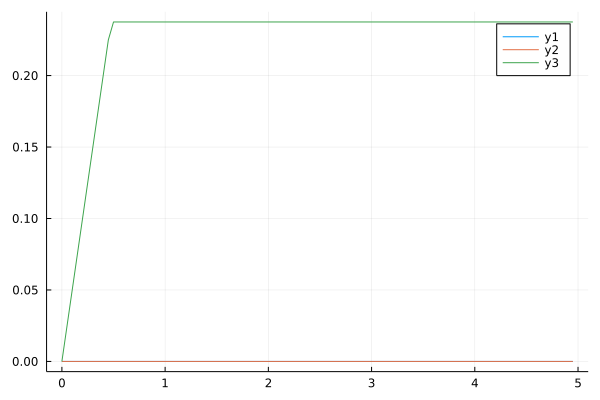

In [52]:
using Plots
Xhist = hcat(X...)'
Vhist = hcat(V...)'
plot(Xhist[:,1:3])
plot(params.Thist[1:end-1], Vhist[:,4:6])

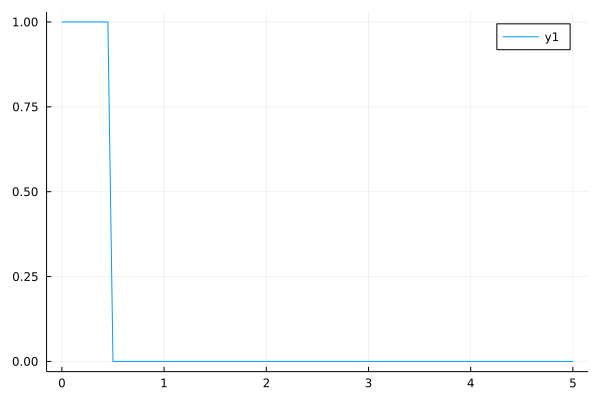

In [30]:
Tz = [f[end] for f in F]
plot(params.Thist, Tz)

In [32]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations, Colors
vis = Visualizer()
dim = Vec(0.5, 0.7, 0.3)
geom  = Rect3D(-dim/2, dim)
setobject!(vis["body"], geom, MeshPhongMaterial(color=colorant"green"))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat Visualizer with path /meshcat/body at http://127.0.0.1:8700

In [33]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8700))

In [35]:
anim = MeshCat.Animation(floor(Int,1/params.h))
for k = 1:params.N
    atframe(anim, k) do
        r = X[k][1:3]
        q = X[k][4:7]
        settransform!(vis["body"], compose(Translation(r), LinearMap(UnitQuaternion(q))))
    end
end
setanimation!(vis, anim)